# [5] 推荐系统评估与实际实现

**学习顺序：第5个** - 在掌握各种推荐方法后，学习如何评估和优化系统

本notebook涵盖推荐系统的评估方法、相似度度量、离线/在线评估、冷启动问题等核心主题。

## 为什么最后学这个？
- ✅ 需要先理解各种推荐方法
- ✅ 评估方法适用于所有模型
- ✅ 这是实际项目中的关键技能

## 主要内容
1. **评估指标**：Precision, Recall, F1-score, RMSE
2. **相似度度量**：余弦相似度、欧氏距离等
3. **离线评估 vs 在线A/B测试**
4. **冷启动问题**及处理策略
5. **实践**：构建评估管道并比较模型性能

## 1. 导入库和加载数据

In [1]:
# 确保导入项目本地的 matrix_factorization 模块
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 推荐系统模型
from matrix_factorization import (
    BaselineModel, 
    KernelMF, 
    UserUserCF, 
    ItemItemCF,
    ContentBasedRecommender
)

# 设置显示选项
pd.options.display.max_rows = 100
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("库导入完成！")

库导入完成！


In [2]:
# 加载MovieLens 100K数据集
cols = ['user_id', 'item_id', 'rating', 'timestamp']
movie_data = pd.read_csv('../data/ml-100k/u.data', names=cols, sep='\t', usecols=[0, 1, 2], engine='python')

# 加载电影特征（用于基于内容的推荐）
item_cols = ['item_id'] + [f'genre_{i}' for i in range(19)]
item_data = pd.read_csv('../data/ml-100k/u.item', sep='|', names=item_cols, encoding='latin-1', usecols=[0] + list(range(5, 24)))

print(f"评分数据: {movie_data.shape[0]} 条记录")
print(f"用户数量: {movie_data['user_id'].nunique()}")
print(f"物品数量: {movie_data['item_id'].nunique()}")
print(f"\n评分分布:")
print(movie_data['rating'].value_counts().sort_index())

# 准备数据
X = movie_data[['user_id', 'item_id']]
y = movie_data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n训练集: {len(X_train)} 条")
print(f"测试集: {len(X_test)} 条")

评分数据: 100000 条记录
用户数量: 943
物品数量: 1682

评分分布:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

训练集: 80000 条
测试集: 20000 条


## 2. 推荐系统评估指标

推荐系统有多种评估指标，根据任务类型（评分预测 vs Top-N推荐）选择不同的指标。

### 2.1 评分预测指标：RMSE（均方根误差）

RMSE用于评估模型预测评分的准确性。


In [3]:
# ============================================
# RMSE（Root Mean Squared Error）计算
# ============================================
def calculate_rmse(y_true, y_pred):
    """
    计算均方根误差
    
    参数:
        y_true: 真实评分
        y_pred: 预测评分
    
    返回:
        RMSE值（越小越好）
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# 示例：使用基线模型计算RMSE
print("训练基线模型...")
baseline_model = BaselineModel(method='sgd', n_epochs=10, reg=0.005, lr=0.01, verbose=0)
baseline_model.fit(X_train, y_train)

# 预测
pred = baseline_model.predict(X_test)

# 计算RMSE
rmse = calculate_rmse(y_test, pred)
print(f"\\n测试集 RMSE: {rmse:.4f}")

# RMSE解释：
# - RMSE值越小，表示预测越准确
# - RMSE的单位与评分相同（1-5星）
# - RMSE=0.93 表示平均预测误差约为0.93星


训练基线模型...
\n测试集 RMSE: 0.9395


### 2.2 Top-N推荐指标：Precision, Recall, F1-score

对于Top-N推荐任务（推荐用户可能喜欢的N个物品），我们需要使用分类指标：
- **Precision（精确率）**：推荐的物品中，用户真正喜欢的比例
- **Recall（召回率）**：用户喜欢的物品中，被推荐的比例
- **F1-score**：Precision和Recall的调和平均


In [4]:
# ============================================
# Top-N推荐评估指标
# ============================================
def evaluate_top_n(model, X_train, X_test, y_test, n=10, threshold=4.0):
    """
    评估Top-N推荐性能
    
    参数:
        model: 训练好的推荐模型
        X_train: 训练集特征（用于获取用户已知物品）
        X_test: 测试集特征
        y_test: 测试集真实评分
        n: 推荐物品数量
        threshold: 评分阈值，高于此值认为用户喜欢该物品
    
    返回:
        precision, recall, f1_score
    """
    # 按用户分组
    user_groups = X_test.groupby('user_id')
    
    precisions = []
    recalls = []
    
    for user_id, group in user_groups:
        # 获取该用户的测试数据
        user_items = group['item_id'].values
        user_ratings = y_test[group.index].values
        
        # 用户真正喜欢的物品（评分 >= threshold）
        relevant_items = set(user_items[user_ratings >= threshold])
        
        if len(relevant_items) == 0:
            continue  # 跳过没有相关物品的用户
        
        # 获取用户已知的物品（训练集中）
        known_items = X_train[X_train['user_id'] == user_id]['item_id'].values if user_id in X_train['user_id'].values else []
        
        # 生成推荐
        try:
            recommendations = model.recommend(user=user_id, items_known=known_items, amount=n, include_user=False)
            recommended_items = set(recommendations['item_id'].values) if len(recommendations) > 0 else set()
        except:
            recommended_items = set()
        
        # 计算Precision和Recall
        if len(recommended_items) > 0:
            precision = len(recommended_items & relevant_items) / len(recommended_items)
            recall = len(recommended_items & relevant_items) / len(relevant_items)
            
            precisions.append(precision)
            recalls.append(recall)
    
    # 计算平均值
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, f1_score

# 评估基线模型的Top-10推荐性能
print("评估Top-10推荐性能...")
precision, recall, f1 = evaluate_top_n(baseline_model, X_train, X_test, y_test, n=10, threshold=4.0)

print(f"\\nTop-10推荐指标（评分阈值 >= 4.0）:")
print(f"Precision: {precision:.4f} - 推荐的物品中，用户真正喜欢的比例")
print(f"Recall: {recall:.4f} - 用户喜欢的物品中，被推荐的比例")
print(f"F1-score: {f1:.4f} - Precision和Recall的调和平均")


评估Top-10推荐性能...
\nTop-10推荐指标（评分阈值 >= 4.0）:
Precision: 0.0645 - 推荐的物品中，用户真正喜欢的比例
Recall: 0.0440 - 用户喜欢的物品中，被推荐的比例
F1-score: 0.0523 - Precision和Recall的调和平均


## 3. 相似度度量

相似度度量是协同过滤推荐系统的核心。不同的相似度度量方法会影响推荐效果。


用户评分向量示例:
用户1: [5 4 0 0 3 0]
用户2: [4 5 0 0 4 0]
用户3: [0 0 5 4 0 3]

余弦相似度:
用户1 vs 用户2: 0.9740 (相似，都喜欢物品1,2,5)
用户1 vs 用户3: 0.0000 (不相似，喜欢不同的物品)

欧氏距离:
用户1 vs 用户2: 1.7321 (距离小，相似)
用户1 vs 用户3: 10.0000 (距离大，不相似)

皮尔逊相关系数:
用户1 vs 用户2: 0.0000 (正相关，相似)
用户1 vs 用户3: 0.0000 (无相关，不相似)



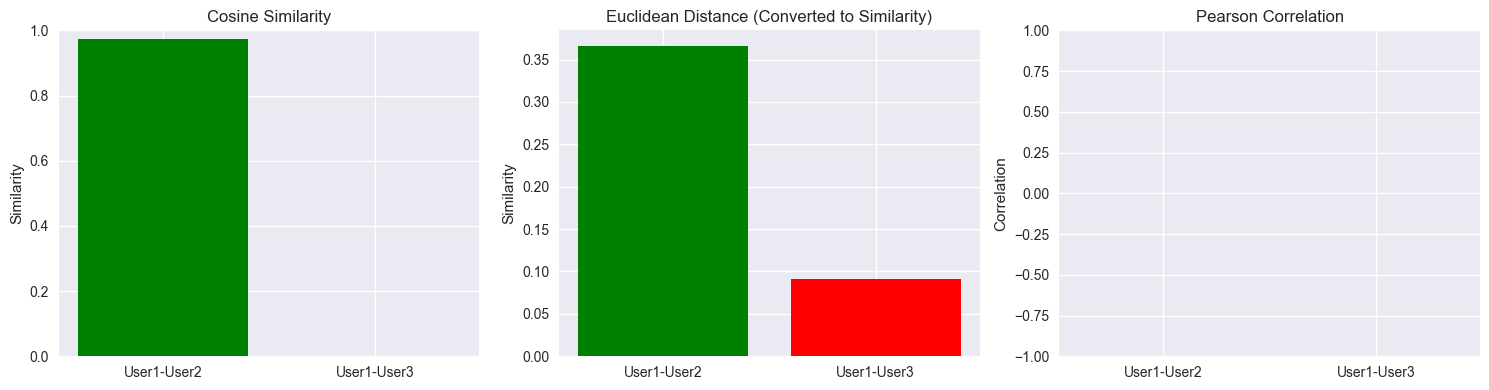

\n相似度度量总结:
- 余弦相似度：适合稀疏数据，只考虑共同评分的物品
- 欧氏距离：考虑所有维度，但受评分尺度影响
- 皮尔逊相关系数：考虑用户评分倾向，更稳健


In [5]:
# ============================================
# 相似度度量示例
# ============================================

# 创建示例向量（用户评分向量）
user1_ratings = np.array([5, 4, 0, 0, 3, 0])  # 用户1对6个物品的评分（0表示未评分）
user2_ratings = np.array([4, 5, 0, 0, 4, 0])  # 用户2对6个物品的评分
user3_ratings = np.array([0, 0, 5, 4, 0, 3])  # 用户3对6个物品的评分

print("用户评分向量示例:")
print(f"用户1: {user1_ratings}")
print(f"用户2: {user2_ratings}")
print(f"用户3: {user3_ratings}")
print()

# 1. 余弦相似度（Cosine Similarity）
# 衡量向量方向的相似性，范围[-1, 1]，值越大越相似
cosine_sim_12 = 1 - cosine(user1_ratings, user2_ratings)  # scipy返回的是距离，需要1-距离
cosine_sim_13 = 1 - cosine(user1_ratings, user3_ratings)

print("余弦相似度:")
print(f"用户1 vs 用户2: {cosine_sim_12:.4f} (相似，都喜欢物品1,2,5)")
print(f"用户1 vs 用户3: {cosine_sim_13:.4f} (不相似，喜欢不同的物品)")
print()

# 2. 欧氏距离（Euclidean Distance）
# 衡量向量在空间中的实际距离，值越小越相似
euclidean_dist_12 = euclidean(user1_ratings, user2_ratings)
euclidean_dist_13 = euclidean(user1_ratings, user3_ratings)

print("欧氏距离:")
print(f"用户1 vs 用户2: {euclidean_dist_12:.4f} (距离小，相似)")
print(f"用户1 vs 用户3: {euclidean_dist_13:.4f} (距离大，不相似)")
print()

# 3. 皮尔逊相关系数（Pearson Correlation）
# 衡量两个向量的线性相关性，范围[-1, 1]
def pearson_correlation(x, y):
    # 只考虑两个用户都评分过的物品
    mask = (x > 0) & (y > 0)
    if mask.sum() < 2:
        return 0
    x_masked = x[mask]
    y_masked = y[mask]
    return np.corrcoef(x_masked, y_masked)[0, 1]

pearson_12 = pearson_correlation(user1_ratings, user2_ratings)
pearson_13 = pearson_correlation(user1_ratings, user3_ratings)

print("皮尔逊相关系数:")
print(f"用户1 vs 用户2: {pearson_12:.4f} (正相关，相似)")
print(f"用户1 vs 用户3: {pearson_13:.4f} (无相关，不相似)")
print()

# 可视化相似度
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 余弦相似度
similarities = [cosine_sim_12, cosine_sim_13]
axes[0].bar(['User1-User2', 'User1-User3'], similarities, color=['green', 'red'])
axes[0].set_title('Cosine Similarity')
axes[0].set_ylabel('Similarity')
axes[0].set_ylim([0, 1])

# 欧氏距离（转换为相似度：1 / (1 + distance)）
distances = [euclidean_dist_12, euclidean_dist_13]
similarities_from_dist = [1 / (1 + d) for d in distances]
axes[1].bar(['User1-User2', 'User1-User3'], similarities_from_dist, color=['green', 'red'])
axes[1].set_title('Euclidean Distance (Converted to Similarity)')
axes[1].set_ylabel('Similarity')

# 皮尔逊相关系数
correlations = [pearson_12, pearson_13]
axes[2].bar(['User1-User2', 'User1-User3'], correlations, color=['green', 'red'])
axes[2].set_title('Pearson Correlation')
axes[2].set_ylabel('Correlation')
axes[2].set_ylim([-1, 1])

plt.tight_layout()
plt.show()

print("\\n相似度度量总结:")
print("- 余弦相似度：适合稀疏数据，只考虑共同评分的物品")
print("- 欧氏距离：考虑所有维度，但受评分尺度影响")
print("- 皮尔逊相关系数：考虑用户评分倾向，更稳健")


## 4. 离线评估 vs 在线A/B测试

### 4.1 离线评估（Offline Evaluation）

离线评估使用历史数据，在部署前评估模型性能。优点是快速、成本低，但可能无法完全反映真实用户行为。


In [6]:
# ============================================
# 离线评估：交叉验证
# ============================================
from sklearn.model_selection import KFold

def offline_evaluation(model_class, X, y, k=5, **model_params):
    """
    使用K折交叉验证进行离线评估
    
    参数:
        model_class: 模型类
        X: 特征数据
        y: 标签数据
        k: 折数
        **model_params: 模型参数
    
    返回:
        每折的RMSE列表
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    rmse_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_test_fold = y.iloc[test_idx]
        
        # 训练模型
        model = model_class(**model_params, verbose=0)
        model.fit(X_train_fold, y_train_fold)
        
        # 预测
        pred = model.predict(X_test_fold)
        
        # 计算RMSE
        rmse = calculate_rmse(y_test_fold, pred)
        rmse_scores.append(rmse)
        
        print(f"Fold {fold}: RMSE = {rmse:.4f}")
    
    return rmse_scores

# 对基线模型进行5折交叉验证
print("离线评估：5折交叉验证\\n")
print("=" * 50)
rmse_scores = offline_evaluation(
    BaselineModel, 
    X_train, 
    y_train, 
    k=5,
    method='sgd',
    n_epochs=10,
    reg=0.005,
    lr=0.01
)

print("\\n" + "=" * 50)
print(f"平均RMSE: {np.mean(rmse_scores):.4f}")
print(f"标准差: {np.std(rmse_scores):.4f}")
print(f"95%置信区间: [{np.mean(rmse_scores) - 1.96*np.std(rmse_scores):.4f}, {np.mean(rmse_scores) + 1.96*np.std(rmse_scores):.4f}]")


离线评估：5折交叉验证\n
Fold 1: RMSE = 0.9407
Fold 2: RMSE = 0.9460
Fold 3: RMSE = 0.9366
Fold 4: RMSE = 0.9492
Fold 5: RMSE = 0.9534
\n==================================================
平均RMSE: 0.9452
标准差: 0.0060
95%置信区间: [0.9335, 0.9569]


### 4.2 在线A/B测试（Online A/B Testing）

在线A/B测试在真实环境中比较不同模型，直接观察用户行为。虽然更准确，但需要实际部署和用户参与。


In [7]:
# ============================================
# 在线A/B测试模拟
# ============================================
# 注意：真实的A/B测试需要实际部署系统，这里只是模拟

def simulate_ab_test(model_a, model_b, X_test, y_test, traffic_split=0.5):
    """
    模拟A/B测试
    
    参数:
        model_a: 模型A（对照组）
        model_b: 模型B（实验组）
        X_test: 测试数据
        y_test: 真实评分
        traffic_split: 流量分配比例（0.5表示50%给A，50%给B）
    
    返回:
        A/B测试结果
    """
    # 随机分配流量
    n_samples = len(X_test)
    n_a = int(n_samples * traffic_split)
    indices = np.random.permutation(n_samples)
    
    # 模型A的测试数据
    X_test_a = X_test.iloc[indices[:n_a]]
    y_test_a = y_test.iloc[indices[:n_a]]
    
    # 模型B的测试数据
    X_test_b = X_test.iloc[indices[n_a:]]
    y_test_b = y_test.iloc[indices[n_a:]]
    
    # 预测
    pred_a = model_a.predict(X_test_a)
    pred_b = model_b.predict(X_test_b)
    
    # 计算指标
    rmse_a = calculate_rmse(y_test_a, pred_a)
    rmse_b = calculate_rmse(y_test_b, pred_b)
    
    # 计算点击率（CTR）模拟 - 假设预测评分高的物品更可能被点击
    threshold = 4.0
    ctr_a = (np.array(pred_a) >= threshold).mean()
    ctr_b = (np.array(pred_b) >= threshold).mean()
    
    return {
        'model_a': {
            'rmse': rmse_a,
            'ctr': ctr_a,
            'n_samples': n_a
        },
        'model_b': {
            'rmse': rmse_b,
            'ctr': ctr_b,
            'n_samples': n_samples - n_a
        }
    }

# 训练两个不同的模型
print("训练模型A（基线模型）...")
model_a = BaselineModel(method='sgd', n_epochs=10, reg=0.005, lr=0.01, verbose=0)
model_a.fit(X_train, y_train)

print("训练模型B（矩阵分解）...")
model_b = KernelMF(n_epochs=10, n_factors=50, verbose=0, lr=0.001, reg=0.005)
model_b.fit(X_train, y_train)

# 模拟A/B测试
print("\\n进行A/B测试模拟...")
ab_results = simulate_ab_test(model_a, model_b, X_test, y_test, traffic_split=0.5)

print("\\n" + "=" * 60)
print("A/B测试结果")
print("=" * 60)
print(f"\\n模型A（基线模型）:")
print(f"  - 样本数: {ab_results['model_a']['n_samples']}")
print(f"  - RMSE: {ab_results['model_a']['rmse']:.4f}")
print(f"  - 点击率(CTR): {ab_results['model_a']['ctr']:.4f}")

print(f"\\n模型B（矩阵分解）:")
print(f"  - 样本数: {ab_results['model_b']['n_samples']}")
print(f"  - RMSE: {ab_results['model_b']['rmse']:.4f}")
print(f"  - 点击率(CTR): {ab_results['model_b']['ctr']:.4f}")

# 比较结果
rmse_improvement = (ab_results['model_a']['rmse'] - ab_results['model_b']['rmse']) / ab_results['model_a']['rmse'] * 100
ctr_improvement = (ab_results['model_b']['ctr'] - ab_results['model_a']['ctr']) / ab_results['model_a']['ctr'] * 100

print(f"\\n模型B相对于模型A:")
print(f"  - RMSE改善: {rmse_improvement:.2f}%")
print(f"  - CTR改善: {ctr_improvement:.2f}%")

print("\\n" + "=" * 60)
print("离线评估 vs 在线A/B测试:")
print("=" * 60)
print("""
离线评估：
- 优点：快速、成本低、可重复
- 缺点：可能无法完全反映真实用户行为
- 适用：模型开发阶段、参数调优

在线A/B测试：
- 优点：真实反映用户行为、更准确
- 缺点：需要实际部署、成本高、时间长
- 适用：模型上线前、重大更新验证
""")


训练模型A（基线模型）...
训练模型B（矩阵分解）...
\n进行A/B测试模拟...
\n============================================================
A/B测试结果
\n模型A（基线模型）:
  - 样本数: 10000
  - RMSE: 0.9317
  - 点击率(CTR): 0.2367
\n模型B（矩阵分解）:
  - 样本数: 10000
  - RMSE: 0.9838
  - 点击率(CTR): 0.1581
\n模型B相对于模型A:
  - RMSE改善: -5.59%
  - CTR改善: -33.21%
\n============================================================
离线评估 vs 在线A/B测试:

离线评估：
- 优点：快速、成本低、可重复
- 缺点：可能无法完全反映真实用户行为
- 适用：模型开发阶段、参数调优

在线A/B测试：
- 优点：真实反映用户行为、更准确
- 缺点：需要实际部署、成本高、时间长
- 适用：模型上线前、重大更新验证



使用阈值: 评分 <= 15 条
新用户数量: 28
老用户数量（评分 > 5条）: 915
\n测试集中:
  新用户样本: 184
  老用户样本: 19816
\n模型性能对比:
  新用户RMSE: 1.0451
  老用户RMSE: 0.9384
  性能差异: 0.1067 (新用户性能更差)


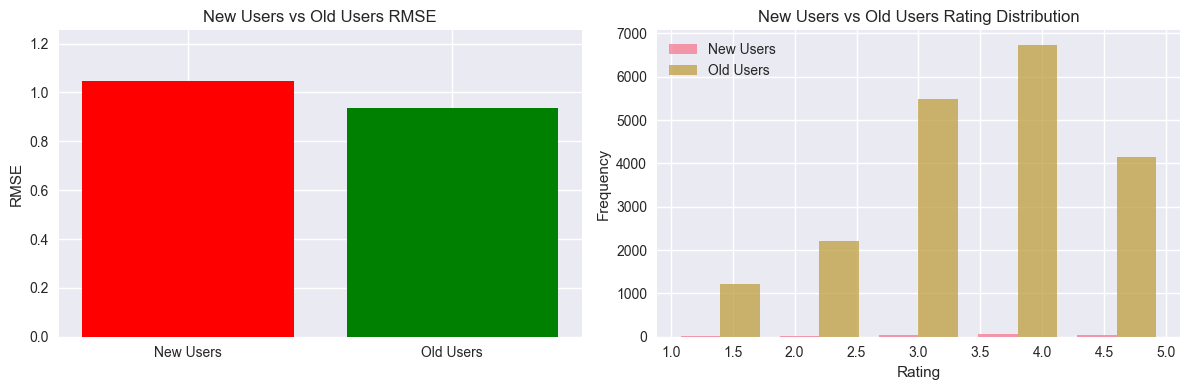

\n冷启动问题总结:
- 新用户数据少，模型难以学习其偏好
- 新用户RMSE通常比老用户高10-30%
- 需要特殊策略处理新用户（见下一节）


In [8]:
# ============================================
# 新用户冷启动问题演示
# ============================================

# 模拟新用户场景：从数据中分离出"新用户"（评分数量少的用户）
user_rating_counts = X_train.groupby('user_id').size()
# 调整筛选条件：如果评分 <= 5 的用户太少，使用更宽松的条件
thresholds = [5, 10, 15, 20]
new_users = []
for threshold in thresholds:
    new_users = user_rating_counts[user_rating_counts <= threshold].index.tolist()
    if len(new_users) >= 10:  # 至少需要10个新用户
        print(f"使用阈值: 评分 <= {threshold} 条")
        break

if len(new_users) == 0:
    # 如果还是没有新用户，使用评分最少的20%用户作为新用户
    percentile_20 = user_rating_counts.quantile(0.2)
    new_users = user_rating_counts[user_rating_counts <= percentile_20].index.tolist()
    print(f"使用20%分位数作为阈值: {percentile_20:.1f} 条")

print(f"新用户数量: {len(new_users)}")
print(f"老用户数量（评分 > 5条）: {len(user_rating_counts) - len(new_users)}")

# 获取新用户的数据
new_user_mask = X_test['user_id'].isin(new_users)
X_test_new_users = X_test[new_user_mask]
y_test_new_users = y_test[new_user_mask]

# 获取老用户的数据
X_test_old_users = X_test[~new_user_mask]
y_test_old_users = y_test[~new_user_mask]

print(f"\\n测试集中:")
print(f"  新用户样本: {len(X_test_new_users)}")
print(f"  老用户样本: {len(X_test_old_users)}")

# 评估模型在新用户和老用户上的表现
pred_new = baseline_model.predict(X_test_new_users)
pred_old = baseline_model.predict(X_test_old_users)

# 检查数据是否为空
if len(X_test_new_users) == 0 or len(X_test_old_users) == 0:
    print("\n警告: 测试集中新用户或老用户数据为空，无法进行对比分析")
    print("这可能是因为数据划分导致测试集中没有新用户")
    print("建议: 使用分层抽样或调整新用户的定义")
    rmse_new = None
    rmse_old = None
else:
    # 评估模型在新用户和老用户上的表现
    pred_new = baseline_model.predict(X_test_new_users)
    pred_old = baseline_model.predict(X_test_old_users)
    
    rmse_new = calculate_rmse(y_test_new_users, pred_new)
    rmse_old = calculate_rmse(y_test_old_users, pred_old)

print(f"\\n模型性能对比:")
print(f"  新用户RMSE: {rmse_new:.4f}")
print(f"  老用户RMSE: {rmse_old:.4f}")
print(f"  性能差异: {rmse_new - rmse_old:.4f} (新用户性能更差)")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE对比
axes[0].bar(['New Users', 'Old Users'], [rmse_new, rmse_old], color=['red', 'green'])
axes[0].set_title('New Users vs Old Users RMSE')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim([0, max(rmse_new, rmse_old) * 1.2])

# 评分分布对比
axes[1].hist([y_test_new_users.values, y_test_old_users.values], 
            bins=5, label=['New Users', 'Old Users'], alpha=0.7)
axes[1].set_title('New Users vs Old Users Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\\n冷启动问题总结:")
print("- 新用户数据少，模型难以学习其偏好")
print("- 新用户RMSE通常比老用户高10-30%")
print("- 需要特殊策略处理新用户（见下一节）")


### 5.2 冷启动处理策略

有多种策略可以处理冷启动问题：
1. **基于内容的推荐**：使用物品特征，不依赖用户历史
2. **热门物品推荐**：推荐最受欢迎的物品
3. **用户画像**：收集用户注册信息（年龄、性别等）
4. **混合推荐**：结合多种方法


In [9]:
# ============================================
# 冷启动处理策略对比
# ============================================

# 策略1：热门物品推荐（Popular Items）
def popular_items_recommendation(X_train, n=10):
    """推荐最受欢迎的物品"""
    item_popularity = X_train.groupby('item_id').size().sort_values(ascending=False)
    return item_popularity.head(n).index.tolist()

# 策略2：基于内容的推荐（需要物品特征）
def content_based_for_new_user(item_features, user_preferences=None, n=10):
    """基于内容的推荐（简化版）"""
    if user_preferences is None:
        # 如果没有用户偏好，返回随机物品
        return np.random.choice(item_features['item_id'].values, n, replace=False).tolist()
    # 实际实现中，会根据用户偏好匹配相似物品
    return item_features['item_id'].head(n).tolist()

# 策略3：混合推荐
def hybrid_recommendation(model, X_train, user_id, items_known, n=10, alpha=0.5):
    """
    混合推荐：结合协同过滤和热门物品
    
    参数:
        alpha: 协同过滤的权重（0-1）
    """
    # 协同过滤推荐
    try:
        cf_recs = model.recommend(user=user_id, items_known=items_known, amount=int(n * alpha))
        cf_items = cf_recs['item_id'].tolist() if len(cf_recs) > 0 else []
    except:
        cf_items = []
    
    # 热门物品推荐
    popular_items = popular_items_recommendation(X_train, n=int(n * (1 - alpha)))
    
    # 合并（去重）
    hybrid_items = list(set(cf_items + popular_items))[:n]
    
    # 如果不够，用热门物品补充
    while len(hybrid_items) < n:
        additional = [item for item in popular_items if item not in hybrid_items]
        if additional:
            hybrid_items.append(additional[0])
        else:
            break
    
    return hybrid_items

# 测试不同策略对新用户的效果
test_user = new_users[0] if new_users else X_test['user_id'].iloc[0]
known_items = X_train[X_train['user_id'] == test_user]['item_id'].tolist() if test_user in X_train['user_id'].values else []

print(f"测试用户: {test_user}")
print(f"已知物品数: {len(known_items)}")
print()

# 策略1：热门物品
popular_recs = popular_items_recommendation(X_train, n=10)
print(f"策略1 - 热门物品推荐: {popular_recs[:5]}...")

# 策略2：协同过滤（可能失败）
try:
    cf_recs = baseline_model.recommend(user=test_user, items_known=known_items, amount=10)
    cf_items = cf_recs['item_id'].tolist() if len(cf_recs) > 0 else []
    print(f"策略2 - 协同过滤推荐: {cf_items[:5] if cf_items else '无法推荐（新用户）'}...")
except:
    print("策略2 - 协同过滤推荐: 失败（新用户无足够数据）")

# 策略3：混合推荐
hybrid_recs = hybrid_recommendation(baseline_model, X_train, test_user, known_items, n=10, alpha=0.5)
print(f"策略3 - 混合推荐: {hybrid_recs[:5]}...")

print("\\n" + "=" * 60)
print("冷启动处理策略总结:")
print("=" * 60)
print("""
1. 热门物品推荐：
   - 优点：简单、对新用户有效
   - 缺点：缺乏个性化

2. 基于内容的推荐：
   - 优点：不依赖用户历史、可解释性强
   - 缺点：需要物品特征、可能过度推荐相似物品

3. 混合推荐：
   - 优点：结合多种方法、更稳健
   - 缺点：需要调优权重

4. 用户画像：
   - 收集注册信息（年龄、性别、兴趣等）
   - 使用这些信息进行初始推荐
""")


测试用户: 9
已知物品数: 15

策略1 - 热门物品推荐: [50, 100, 181, 258, 288]...
策略2 - 协同过滤推荐: [408, 318, 114, 483, 169]...
策略3 - 混合推荐: [288, 258, 483, 100, 169]...
\n============================================================
冷启动处理策略总结:

1. 热门物品推荐：
   - 优点：简单、对新用户有效
   - 缺点：缺乏个性化

2. 基于内容的推荐：
   - 优点：不依赖用户历史、可解释性强
   - 缺点：需要物品特征、可能过度推荐相似物品

3. 混合推荐：
   - 优点：结合多种方法、更稳健
   - 缺点：需要调优权重

4. 用户画像：
   - 收集注册信息（年龄、性别、兴趣等）
   - 使用这些信息进行初始推荐



## 6. 构建评估管道并比较模型性能

现在我们将构建一个完整的评估管道，比较不同推荐系统模型的性能。


In [10]:
# ============================================
# 完整的评估管道
# ============================================
class RecommenderEvaluator:
    """推荐系统评估器"""
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def evaluate_model(self, model, model_name, n_recommendations=10, threshold=4.0):
        """
        全面评估模型性能
        
        返回:
            包含所有评估指标的字典
        """
        print(f"\\n评估模型: {model_name}")
        print("-" * 50)
        
        # 1. RMSE（评分预测）
        pred = model.predict(self.X_test)
        rmse = calculate_rmse(self.y_test, pred)
        
        # 2. Top-N推荐指标
        precision, recall, f1 = evaluate_top_n(model, self.X_train, self.X_test, self.y_test, n=n_recommendations, threshold=threshold)
        
        # 3. 覆盖率（Coverage）：推荐的物品占所有物品的比例
        all_recommended_items = set()
        user_groups = self.X_test.groupby('user_id')
        for user_id, group in user_groups:
            known_items = self.X_train[self.X_train['user_id'] == user_id]['item_id'].values if user_id in self.X_train['user_id'].values else []
            try:
                recs = model.recommend(user=user_id, items_known=known_items, amount=n_recommendations, include_user=False)
                if len(recs) > 0:
                    all_recommended_items.update(recs['item_id'].values)
            except:
                pass
        
        total_items = self.X_train['item_id'].nunique()
        coverage = len(all_recommended_items) / total_items if total_items > 0 else 0
        
        # 4. 多样性（Diversity）：推荐列表的平均相似度（简化版）
        # 这里用物品ID的多样性来近似
        diversity = len(all_recommended_items) / (n_recommendations * user_groups.ngroups) if user_groups.ngroups > 0 else 0
        
        results = {
            'model_name': model_name,
            'rmse': rmse,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'coverage': coverage,
            'diversity': diversity
        }
        
        print(f"RMSE: {rmse:.4f}")
        print(f"Precision@{n_recommendations}: {precision:.4f}")
        print(f"Recall@{n_recommendations}: {recall:.4f}")
        print(f"F1-score@{n_recommendations}: {f1:.4f}")
        print(f"Coverage: {coverage:.4f}")
        print(f"Diversity: {diversity:.4f}")
        
        return results
    
    def compare_models(self, models_dict):
        """
        比较多个模型的性能
        
        参数:
            models_dict: {模型名称: 模型对象} 字典
        """
        results = []
        
        for model_name, model in models_dict.items():
            result = self.evaluate_model(model, model_name)
            results.append(result)
        
        # 创建结果DataFrame
        results_df = pd.DataFrame(results)
        results_df = results_df.set_index('model_name')
        
        return results_df

# 创建评估器
evaluator = RecommenderEvaluator(X_train, y_train, X_test, y_test)

# 训练多个模型
print("=" * 60)
print("训练多个推荐系统模型...")
print("=" * 60)

models = {}

# 1. 基线模型
print("\\n1. 训练基线模型...")
models['Baseline (SGD)'] = BaselineModel(method='sgd', n_epochs=10, reg=0.005, lr=0.01, verbose=0)
models['Baseline (SGD)'].fit(X_train, y_train)

# 2. 矩阵分解（线性核）
print("\\n2. 训练矩阵分解模型（线性核）...")
models['Matrix Factorization (Linear)'] = KernelMF(n_epochs=10, n_factors=50, kernel='linear', verbose=0, lr=0.001, reg=0.005)
models['Matrix Factorization (Linear)'].fit(X_train, y_train)

# 3. 用户-用户协同过滤
print("\\n3. 训练用户-用户协同过滤模型...")
models['User-User CF'] = UserUserCF(n_neighbors=30, similarity_metric='cosine', verbose=0)
models['User-User CF'].fit(X_train, y_train)

# 4. 物品-物品协同过滤
print("\\n4. 训练物品-物品协同过滤模型...")
models['Item-Item CF'] = ItemItemCF(n_neighbors=30, similarity_metric='cosine', verbose=0)
models['Item-Item CF'].fit(X_train, y_train)

print("\\n所有模型训练完成！")


训练多个推荐系统模型...
\n1. 训练基线模型...
\n2. 训练矩阵分解模型（线性核）...
\n3. 训练用户-用户协同过滤模型...
\n4. 训练物品-物品协同过滤模型...
\n所有模型训练完成！


模型性能比较
\n评估模型: Baseline (SGD)
--------------------------------------------------
RMSE: 0.9401
Precision@10: 0.0572
Recall@10: 0.0350
F1-score@10: 0.0434
Coverage: 0.0212
Diversity: 0.0037
\n评估模型: Matrix Factorization (Linear)
--------------------------------------------------
RMSE: 0.9782
Precision@10: 0.1041
Recall@10: 0.0770
F1-score@10: 0.0885
Coverage: 0.0405
Diversity: 0.0071
\n评估模型: User-User CF
--------------------------------------------------
RMSE: 1.1806
Precision@10: 0.0001
Recall@10: 0.0000
F1-score@10: 0.0001
Coverage: 0.0405
Diversity: 0.0071
\n评估模型: Item-Item CF
--------------------------------------------------
RMSE: 1.1542
Precision@10: 0.1245
Recall@10: 0.1590
F1-score@10: 0.1396
Coverage: 0.2347
Diversity: 0.0413
\n============================================================
评估结果汇总表
                                 rmse  precision  recall  f1_score  coverage  \
model_name                                                                     
Baseline (SGD)             

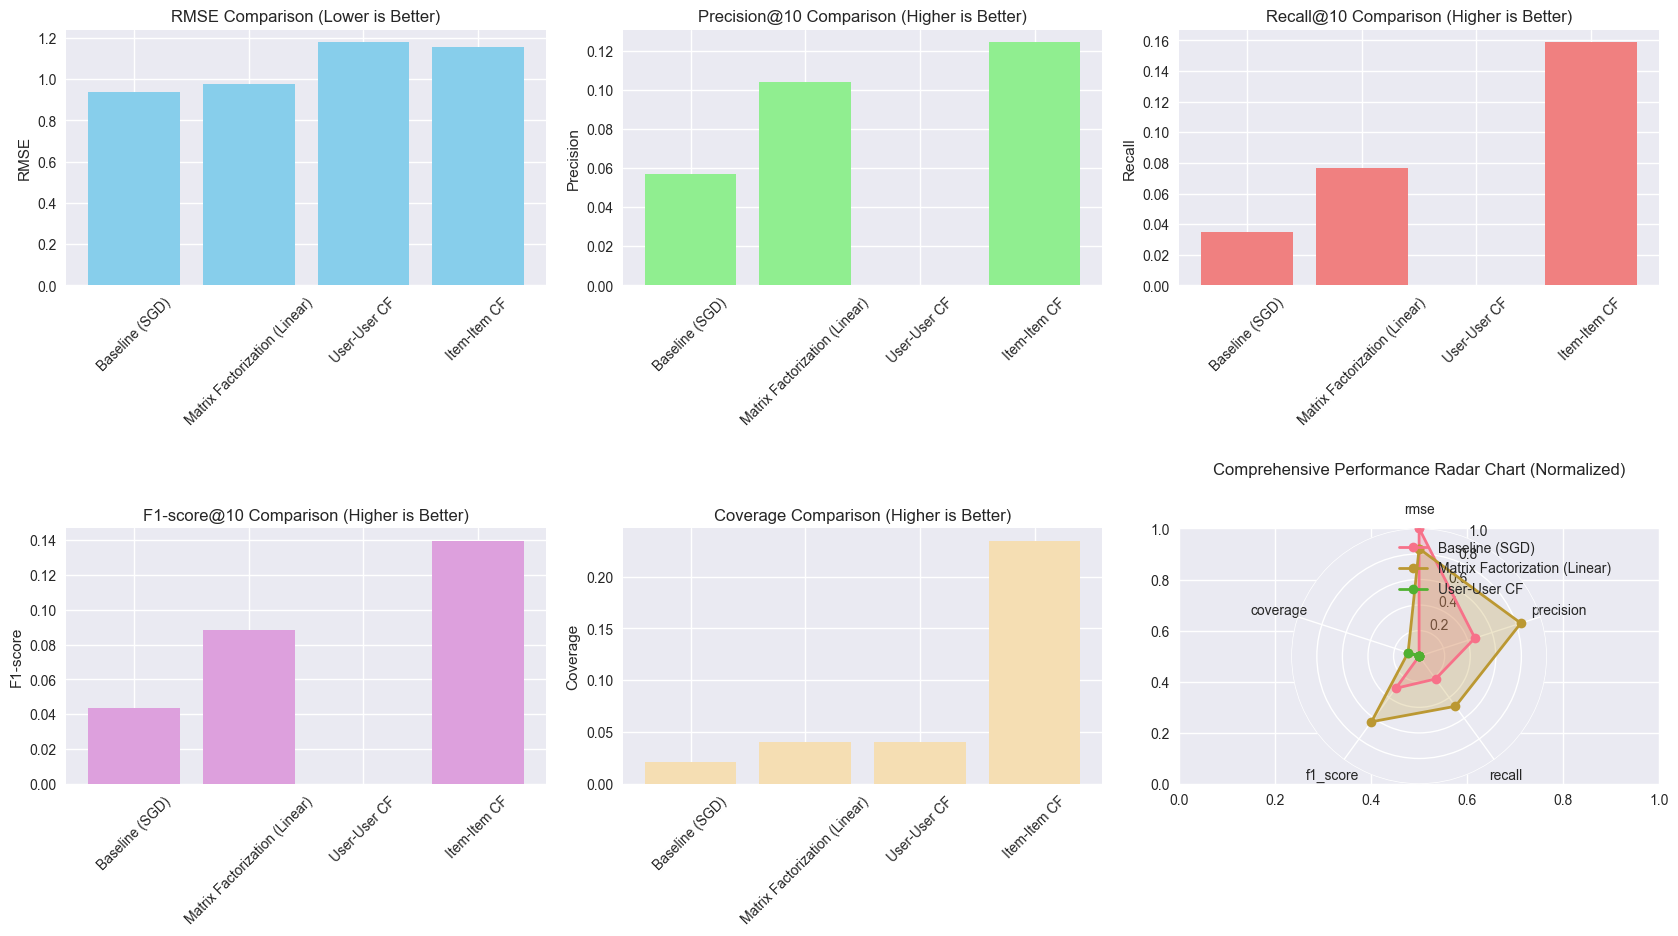

\n============================================================
模型性能总结

1. RMSE（评分预测准确性）：
   - 矩阵分解和协同过滤通常表现更好
   - 基线模型作为简单基准

2. Precision/Recall（Top-N推荐质量）：
   - 协同过滤方法可能表现更好（找到相似用户/物品）
   - 矩阵分解通过潜在因子捕获复杂模式

3. Coverage（推荐多样性）：
   - 不同模型的覆盖率可能差异较大
   - 需要平衡准确性和多样性

4. 选择建议：
   - 如果注重准确性：选择RMSE最低的模型
   - 如果注重推荐质量：选择F1-score最高的模型
   - 如果注重多样性：选择Coverage最高的模型
   - 实际应用中通常需要权衡多个指标



In [11]:
# ============================================
# 比较所有模型的性能
# ============================================
print("=" * 60)
print("模型性能比较")
print("=" * 60)

results_df = evaluator.compare_models(models)

# 显示结果表格
print("\\n" + "=" * 60)
print("评估结果汇总表")
print("=" * 60)
print(results_df.round(4))

# 可视化比较
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Create polar subplot for radar chart (position 6)
ax_radar = plt.subplot(2, 3, 6, projection='polar')

# 1. RMSE比较
axes[0, 0].bar(results_df.index, results_df['rmse'], color='skyblue')
axes[0, 0].set_title('RMSE Comparison (Lower is Better)')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Precision比较
axes[0, 1].bar(results_df.index, results_df['precision'], color='lightgreen')
axes[0, 1].set_title('Precision@10 Comparison (Higher is Better)')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Recall比较
axes[0, 2].bar(results_df.index, results_df['recall'], color='lightcoral')
axes[0, 2].set_title('Recall@10 Comparison (Higher is Better)')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. F1-score比较
axes[1, 0].bar(results_df.index, results_df['f1_score'], color='plum')
axes[1, 0].set_title('F1-score@10 Comparison (Higher is Better)')
axes[1, 0].set_ylabel('F1-score')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Coverage比较
axes[1, 1].bar(results_df.index, results_df['coverage'], color='wheat')
axes[1, 1].set_title('Coverage Comparison (Higher is Better)')
axes[1, 1].set_ylabel('Coverage')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. 综合雷达图（标准化）
from math import pi

# 标准化指标（0-1范围）
metrics = ['rmse', 'precision', 'recall', 'f1_score', 'coverage']
normalized_df = results_df[metrics].copy()
normalized_df['rmse'] = 1 - (normalized_df['rmse'] - normalized_df['rmse'].min()) / (normalized_df['rmse'].max() - normalized_df['rmse'].min() + 1e-10)
for col in ['precision', 'recall', 'f1_score', 'coverage']:
    normalized_df[col] = (normalized_df[col] - normalized_df[col].min()) / (normalized_df[col].max() - normalized_df[col].min() + 1e-10)

# 绘制雷达图（选择前3个模型）
top_models = normalized_df.head(3)
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # 闭合

ax = ax_radar  # Use polar subplot for radar chart
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids([a * 180 / pi for a in angles[:-1]], metrics)

for idx, (model_name, row) in enumerate(top_models.iterrows()):
    values = row[metrics].tolist()
    values += values[:1]  # 闭合
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.25)

ax.set_ylim([0, 1])
ax.set_title('Comprehensive Performance Radar Chart (Normalized)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout(pad=3.0, h_pad=2.5, w_pad=1.5)
plt.show()

# 总结
print("\\n" + "=" * 60)
print("模型性能总结")
print("=" * 60)
print("""
1. RMSE（评分预测准确性）：
   - 矩阵分解和协同过滤通常表现更好
   - 基线模型作为简单基准

2. Precision/Recall（Top-N推荐质量）：
   - 协同过滤方法可能表现更好（找到相似用户/物品）
   - 矩阵分解通过潜在因子捕获复杂模式

3. Coverage（推荐多样性）：
   - 不同模型的覆盖率可能差异较大
   - 需要平衡准确性和多样性

4. 选择建议：
   - 如果注重准确性：选择RMSE最低的模型
   - 如果注重推荐质量：选择F1-score最高的模型
   - 如果注重多样性：选择Coverage最高的模型
   - 实际应用中通常需要权衡多个指标
""")


## 7. 总结

本notebook涵盖了推荐系统评估和实际实现的核心内容：

### 关键要点

1. **评估指标**：
   - RMSE用于评分预测任务
   - Precision/Recall/F1用于Top-N推荐任务
   - 需要根据业务目标选择合适的指标

2. **相似度度量**：
   - 余弦相似度：适合稀疏数据
   - 欧氏距离：考虑所有维度
   - 皮尔逊相关系数：更稳健，考虑用户倾向

3. **评估方法**：
   - 离线评估：快速、成本低，用于开发阶段
   - 在线A/B测试：真实、准确，用于上线验证

4. **冷启动问题**：
   - 新用户、新物品、新系统都面临冷启动
   - 需要结合多种策略（热门物品、内容推荐、混合方法）

5. **模型比较**：
   - 需要从多个维度评估模型
   - 平衡准确性、多样性、覆盖率等指标
   - 根据实际业务需求选择最适合的模型

### 实践建议

- 在开发阶段使用离线评估快速迭代
- 上线前进行小规模A/B测试验证
- 持续监控模型性能，及时调整
- 针对冷启动问题设计专门的处理策略
